In [1]:
%pylab
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

import sys
import numpy as np
import pandas as pd
import datetime

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from sklearn.metrics import silhouette_score

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# Variables with the names of each column in data
CDPHID_COLUMN                 = 'CDPHId'
PRODUCTNAME_COLUMN            = 'ProductName'
CSFID_COLUMN                  = 'CSFId'
CSF_COLUMN                    = 'CSF'
COMPANYID_COLUMN              = 'CompanyId'
COMPANYNAME_COLUMN            = 'CompanyName'
BRANDNAME_COLUMN              = 'BrandName'
PRIMARYCATEGORYID_COLUMN      = 'PrimaryCategoryId'
PRIMARYCATEGORY_COLUMN        = 'PrimaryCategory'
SUBCATEGORYID_COLUMN          = 'SubCategoryId'
SUBCATEGORY_COLUMN            = 'SubCategory'
CASID_COLUMN                  = 'CasId'
CASNUMBER_COLUMN              = 'CasNumber'
CHEMICALID_COLUMN             = 'ChemicalId'
CHEMICALNAME_COLUMN           = 'ChemicalName'
INITIALDATEREPORTED_COLUMN    = 'InitialDateReported'
MOSTRECENTDATEREPORTED_COLUMN = 'MostRecentDateReported'
DISCONTINUEDDATE_COLUMN       = 'DiscontinuedDate'
CHEMICALCREATEDAT_COLUMN      = 'ChemicalCreatedAt'
CHEMICALUPDATEDAT_COLUMN      = 'ChemicalUpdatedAt'
CHEMICALDATEREMOVED_COLUMN    = 'ChemicalDateRemoved'
CHEMICALCOUNT_COLUMN          = 'ChemicalCount'

# Date value which means NaT 
NAT_DATE = datetime.date(1900,1,1)

# Number of threads to apply clustering
NUM_THREADS = 8

In [3]:
# List of columns which contains a Names
list_names = [ PRODUCTNAME_COLUMN, CSF_COLUMN, COMPANYNAME_COLUMN, BRANDNAME_COLUMN, 
               PRIMARYCATEGORY_COLUMN, SUBCATEGORY_COLUMN, CHEMICALNAME_COLUMN ]

# List of columns which contains a Dates
list_dates = [ INITIALDATEREPORTED_COLUMN, MOSTRECENTDATEREPORTED_COLUMN, DISCONTINUEDDATE_COLUMN,
               CHEMICALCREATEDAT_COLUMN, CHEMICALUPDATEDAT_COLUMN, CHEMICALDATEREMOVED_COLUMN ]

# Other columns
list_ids = [ CDPHID_COLUMN, CSFID_COLUMN, COMPANYID_COLUMN, PRIMARYCATEGORYID_COLUMN, 
             SUBCATEGORYID_COLUMN, CASID_COLUMN, CHEMICALID_COLUMN ]

In [4]:
# Load data from data/ folder
data = pd.read_csv('data/cscpopendata.csv', sep = ',', parse_dates = list_dates)

# pd.isna() --> for NaN
# <value> is pd.NaT --> for NaT

# Fill NaT with 01/01/2500
for date_column in list_dates :
    data[date_column] = data[date_column].apply(lambda x: NAT_DATE if x is pd.NaT else x)
    

# Fill NA with ''
data = data.fillna('')
data.head()

,CDPHId,ProductName,CSFId,CSF,CompanyId,CompanyName,BrandName,PrimaryCategoryId,PrimaryCategory,SubCategoryId,...,CasNumber,ChemicalId,ChemicalName,InitialDateReported,MostRecentDateReported,DiscontinuedDate,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalDateRemoved,ChemicalCount
0,2,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,,,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),53,...,13463-67-7,6,Titanium dioxide,2009-06-17,2013-08-28,2011-02-01,2009-07-09,2009-07-09,1900-01-01,1
1,3,Glover's Medicated Shampoo,,,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,...,65996-92-1,4,Distillates (coal tar),2009-07-01,2009-07-01,1900-01-01,2009-07-01,2009-07-01,1900-01-01,2
2,3,Glover's Medicated Shampoo,,,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,...,140-67-0,5,Estragole,2009-07-01,2009-07-01,1900-01-01,2009-07-02,2009-07-02,1900-01-01,2
3,4,PRECISION GLIMMER EYE LINER-ALL SHADES �,,,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),46,...,13463-67-7,7,Titanium dioxide,2009-07-09,2013-08-28,1900-01-01,2009-07-09,2009-07-09,1900-01-01,1
4,5,AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES �,,,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),52,...,13463-67-7,8,Titanium dioxide,2009-07-09,2013-08-28,2011-02-01,2009-07-09,2009-07-09,1900-01-01,1


In [5]:
# Add to 'data' a column for each 'date_column' in 'list_dates' with the year and month of each date 
list_year_month = []

for date_column in list_dates :
    data[date_column + '_Year'] = data[date_column].apply(lambda x: x.year)
    data[date_column + '_Month'] = data[date_column].apply(lambda x: x.month)
    
    list_year_month.append(date_column + '_Year')
    list_year_month.append(date_column + '_Month')

# Create a data_aggregate with the sum of 'CHEMICALCOUNT_COLUMN' of the following columns:
# 'list_year_month', 'CASID_COLUMN' and 'SUBCATEGORYID_COLUMN'
data_aggregated = pd.DataFrame(data.groupby(list_year_month + [SUBCATEGORYID_COLUMN, CASID_COLUMN, CHEMICALID_COLUMN], 
                                            as_index = False).agg({CHEMICALCOUNT_COLUMN : 'sum'}))
data_aggregated.head()

,InitialDateReported_Year,InitialDateReported_Month,MostRecentDateReported_Year,MostRecentDateReported_Month,DiscontinuedDate_Year,DiscontinuedDate_Month,ChemicalCreatedAt_Year,ChemicalCreatedAt_Month,ChemicalUpdatedAt_Year,ChemicalUpdatedAt_Month,ChemicalDateRemoved_Year,ChemicalDateRemoved_Month,SubCategoryId,CasId,ChemicalId,ChemicalCount
0,2009,6,2013,8,2011,2,2009,7,2009,7,1900,1,53,656,6,1
1,2009,7,2009,7,1900,1,2009,7,2009,7,1900,1,25,293,5,2
2,2009,7,2009,7,1900,1,2009,7,2009,7,1900,1,25,889,4,2
3,2009,7,2010,6,1900,1,2010,6,2010,6,1900,1,60,656,17909,1
4,2009,7,2010,12,1900,1,2009,12,2009,12,1900,1,60,656,12178,3


In [23]:
def dates_to_clustering(data, date_columns) :
    """
    Convert the columns with date values to timestamp values.
    
    Params:
    data -- data whose columns will be converted.
    date_columns -- list which contains the columns with date values.
    
    Return:
    A data copy with the date columns converted to timestamp.
    """
    
    to_clustering = data.copy(deep = True)
    
    for col in date_columns :
        to_clustering[col] = data[col].apply(lambda x: x.timestamp() if x is pd.Timestamp else x )
        
    return to_clustering


def clustering_to_dates(data, date_columns) :
    """
    Convert the columns with timestamp values to date values.
    
    Params:
    data -- data whose columns will be converted.
    date_columns -- list which contains the columns with timestamp values.
    
    Return:
    A data copy with the date columns converted to date.
    """
        
    to_dates = data.copy(deep = True)
    
    for col in date_columns :
        to_dates[col] = data[col].apply(lambda x: datetime.date.fromtimestamp(x))
        
    return to_dates


def plot_silhouette(data, max_k, n_init, num_threads) :
    """
    Get the number of cluster to apply KMeans using the Silhouette coeffiecient.
    Plot the Silhouette coefficiente before applying KMeans to several number of clusters.
    
    The Silhouette coefficient is defined like the difference between mean distance to closest 
    cluster's elements and mean intra-cluster distance of the cluster's element divide by the maximum of them.
    
    The Silhouette coefficient is implemented in sklearn.metrics with the silhouette_score() method.
    
    Params:
    data        -- data to get the number of clusters.
    max_k       -- maximun of clusters to apply the Silhouette coefficient. It have to be higher than 2.
    n_init      -- maximum number which the algorithm will be executed.
    num_threads -- number of threads to apply clustering.
    """
    
    min_k = 2
    silhouette_avgs = []
    
    for k in range(min_k, max_k):
        # Object kmeans 
        kmeans = KMeans(n_clusters = k, 
                       n_init = n_init, 
                       n_jobs = num_threads)
        # Get Kmeans
        kmeans.fit(data)
        
        score = silhouette_score(data, kmeans.labels_)
        silhouette_avgs.append(score)
    
    # Plot results
    plot(range(min_k, max_k), silhouette_avgs)
    xlabel('k')
    ylabel('silhouette coefficient')


def plot_elbow_method(data, max_k, n_init, num_threads) :
    """
    Get the number of cluster to apply KMeans using the Elbow method. 
    Plot the inertia values before applying KMeans to several number of clusters.
    
    This function has been based on the Elbow's implementation of RicardoMoya:
    
    https://github.com/RicardoMoya/OptimalNumClusters/blob/master/Elbow_Method.py
    
    Params:
    data        -- data to get the number of clusters.
    max_k       -- maximun of clusters to apply the Silhouette coefficient. It have to be higher than 2.
    n_init      -- maximum number which the algorithm will be executed.
    num_threads -- number of threads to apply clustering.
    """
    
    min_k = 2
    inertia_clusters = []
    
    for k in range(min_k, max_k):
        # Object kmeans 
        kmeans = KMeans(n_clusters = k, 
                       n_init = n_init, 
                       n_jobs = num_threads)
        # Get Kmeans
        kmeans.fit(data)
        
        # Obtain inertia
        inertia_clusters.append([k, kmeans.inertia_])
    
    # Plot results
    x, y = zip(*[inertia for inertia in inertia_clusters])
    plt.plot(x, y, 'ro-', markersize=8, lw=2)
    plt.grid(True)
    plt.xlabel('Num Clusters')
    plt.ylabel('Inertia')
    plt.show()

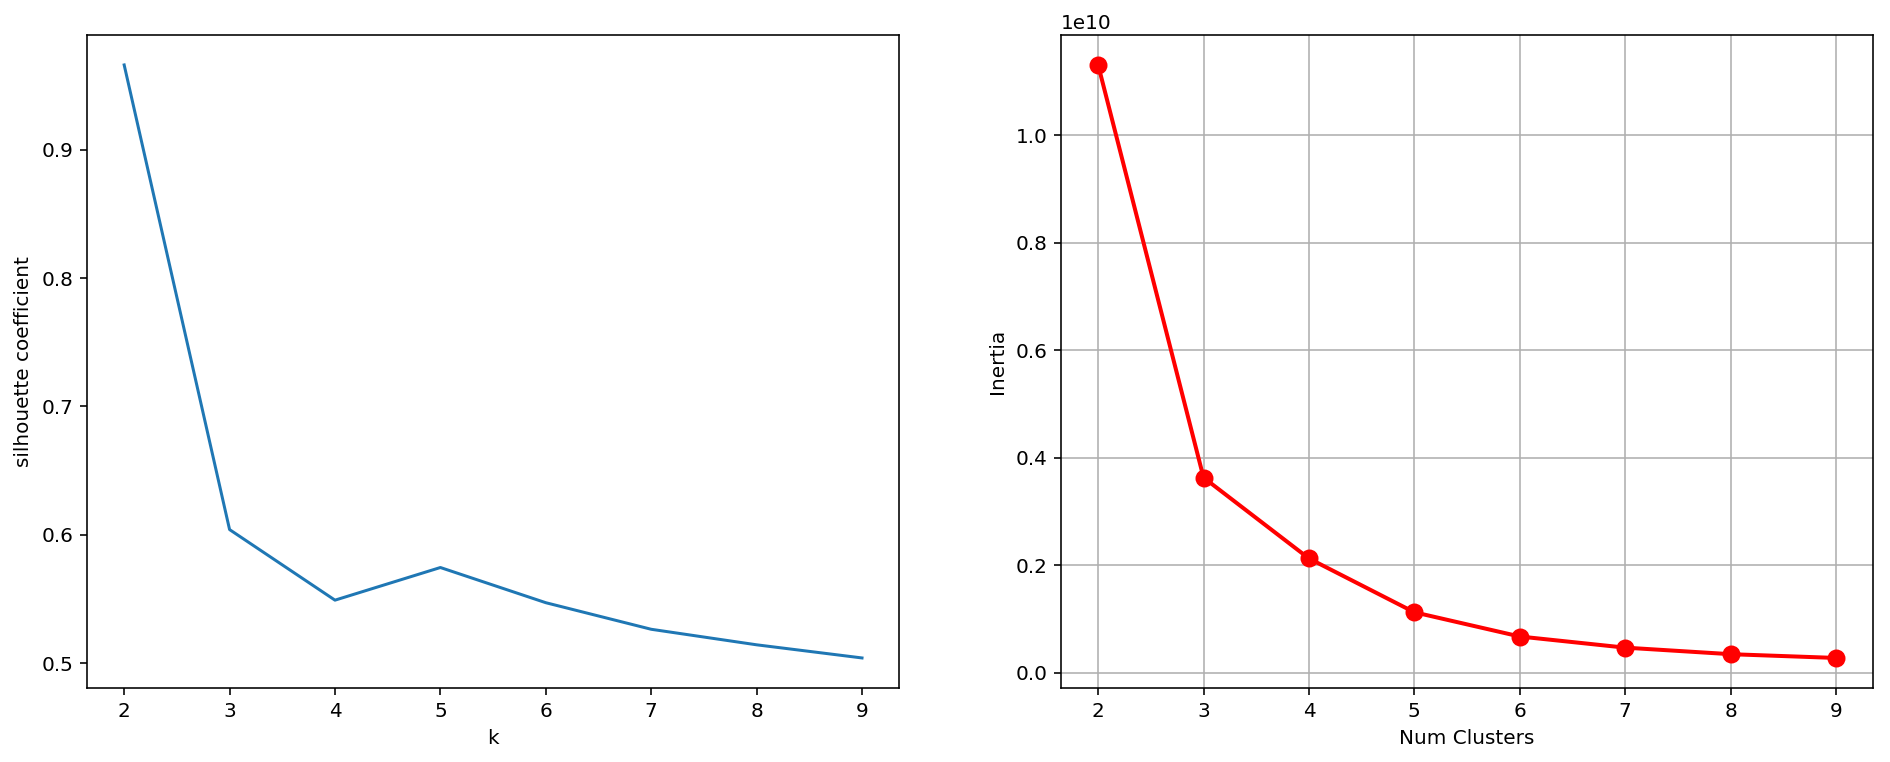

In [27]:
to_clustering = data_aggregated[data_aggregated[(INITIALDATEREPORTED_COLUMN + "_Year")] == 2017]
data_clustering = dates_to_clustering(to_clustering, list_year_month)

max_k = 10
n_init = 10

figure(figsize=(16, 6))
subplot(1, 2, 1)
plot_silhouette(data_clustering, 
                      max_k = max_k, 
                      n_init = n_init, 
                      num_threads = NUM_THREADS)
subplot(1, 2, 2)
plot_elbow_method(data_clustering, 
                      max_k = max_k, 
                      n_init = n_init, 
                      num_threads = NUM_THREADS)

In [ ]:
kmeans = KMeans(n_clusters = n_clusters, 
                n_init = n_init, 
                random_state = 1).fit(data_clustering)

clusters = kmeans.predict(data_clustering)

In [ ]:


# Print the cluster of each chemical
for c in range(max(clusters) + 1) :
    print('Cluster', c)
    
#    for chemicalid in unique(data_clustering[CHEMICALID_COLUMN][clusters == c]) :
#        print(str(unique(data[CASID_COLUMN][data[CHEMICALID_COLUMN] == chemicalid])[0]) + " - " + 
#                  str(chemicalid) + " - " + 
#                  unique(data[CHEMICALNAME_COLUMN][data[CHEMICALID_COLUMN] == chemicalid])[0])
    
    for casid in unique(data_clustering[CASID_COLUMN][clusters == c]) :
        print(str(casid) + " - " + unique(data[CHEMICALNAME_COLUMN][data[CASID_COLUMN] == casid])[0])
        
    print('\n')

In [ ]:
# Remove 'DISCONTINUEDDATE_COLUMN' and 'CHEMICALDATEREMOVED_COLUMN' (and its _Year and _Month columns)
# for the first try with Clustering. Like this, we do not consider that the chemical had been
# removed or the product had been removed from the market
reduced_columns = [ col for col in data_aggregated.columns 
                     if DISCONTINUEDDATE_COLUMN not in col and CHEMICALDATEREMOVED_COLUMN not in col ]

# Only the products which continues in the market
data_continued = data_aggregated[data_aggregated[DISCONTINUEDDATE_COLUMN + "_Year"] == NAT_DATE.year]
print(data_continued.shape)

# Only the productos which have not a removed chemical
data_no_removed_chemical = data_aggregated[data_aggregated[CHEMICALDATEREMOVED_COLUMN + "_Year"] == NAT_DATE.year]
print(data_no_removed_chemical.shape)